# CMPE 255-03, Fall 2024
## Steam CS2 and TF2 Project

**Due Date:** 6:00pm on Oct 30th, 2024

EDA Project for Steam Items in CS2 and TF2

---

In [2]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import glob

Please download fashion_mnist1.csv.
The dataset has 10K rows and 785 columns.

In [9]:
# Load the dataset
data = pd.read_csv('reviews_440.csv')
data.head()

# data.info()

,recommendationid,gameid,steamid,num_games_owned,num_reviews,playtime_forever,playtime_last_two_weeks,playtime_at_review,last_played,language,...,votes_up,votes_funny,weighted_vote_score,comment_count,steam_purchase,received_for_free,written_during_early_access,hidden_in_steam_china,steam_china_location,primarily_steam_deck
0,176534183,440,76561199075358962,0,6,26921,27,26921.0,1728195517,english,...,0,0,0.00000,0,False,False,False,True,NaN,False
1,176533586,440,76561198127158652,1124,68,9220,0,9220.0,1726398332,czech,...,1,0,0.52381,0,False,False,False,True,NaN,False
2,176533564,440,76561199178829199,8,2,36,0,36.0,1645151002,portuguese,...,0,0,0.00000,0,False,False,False,True,NaN,False
3,176533493,440,76561199783055220,0,1,677,516,677.0,1728261916,english,...,0,0,0.00000,0,False,False,False,True,NaN,False
4,176533284,440,76561198157582622,165,9,162721,4986,162721.0,1728259830,english,...,0,0,0.00000,0,False,False,False,True,NaN,False


#### 1. Remove Duplicates from CSV Files

In [3]:
file = pd.read_csv('./CS2Reviews/reviews_730_combined.csv')

file_cleaned = file.drop_duplicates(subset=['recommendationid', 'steamid'], keep=False)

print(file_cleaned.shape[0])

file_cleaned.to_csv("./CS2Reviews/reviews_730_combined_2.csv", index=False)

C:\Users\chaoa\AppData\Local\Temp\ipykernel_22064\3528778444.py:1: DtypeWarning: Columns (22) have mixed types. Specify dtype option on import or set low_memory=False.
  file = pd.read_csv('./CS2Reviews/reviews_730_combined.csv')


8303810


In [10]:
# List of file paths
# C:\Users\chaoa\Downloads\CMPE255\CS2Reviews\reviews_730_01.csv
file_paths = sorted(glob.glob('./CS2Reviews/*.csv'))  # Sort if order matters

print(file_paths)

# Start by loading the first file as the initial base
combined_df = pd.read_csv(file_paths[0])

# Iterate over remaining files and combine without duplicates
for file_path in file_paths[1:]:
    # Load the next file
    next_df = pd.read_csv(file_path)
    
    # Remove entries in `next_df` that already exist in `combined_df`
    next_df = next_df[~next_df['recommendationid'].isin(combined_df['recommendationid'])]
    
    # Concatenate the unique entries to `combined_df`
    combined_df = pd.concat([combined_df, next_df], ignore_index=True)

# Save the final deduplicated result
combined_df.to_csv("./CS2Reviews/CombinedCS2Reviews.csv", index=False)

['./CS2Reviews\\CombinedCS2Reviews.csv', './CS2Reviews\\reviews_730_01.csv', './CS2Reviews\\reviews_730_02.csv', './CS2Reviews\\reviews_730_03.csv', './CS2Reviews\\reviews_730_04.csv', './CS2Reviews\\reviews_730_05.csv', './CS2Reviews\\reviews_730_06.csv', './CS2Reviews\\reviews_730_07.csv', './CS2Reviews\\reviews_730_08.csv', './CS2Reviews\\reviews_730_09.csv', './CS2Reviews\\reviews_730_10.csv', './CS2Reviews\\reviews_730_11.csv', './CS2Reviews\\reviews_730_12.csv', './CS2Reviews\\reviews_730_13.csv', './CS2Reviews\\reviews_730_14.csv', './CS2Reviews\\reviews_730_15.csv', './CS2Reviews\\reviews_730_16.csv', './CS2Reviews\\reviews_730_17.csv', './CS2Reviews\\reviews_730_18.csv', './CS2Reviews\\reviews_730_19.csv', './CS2Reviews\\reviews_730_20.csv', './CS2Reviews\\reviews_730_21.csv', './CS2Reviews\\reviews_730_22.csv', './CS2Reviews\\reviews_730_23.csv', './CS2Reviews\\reviews_730_combined.csv']


C:\Users\chaoa\AppData\Local\Temp\ipykernel_31988\1463797543.py:10: DtypeWarning: Columns (22) have mixed types. Specify dtype option on import or set low_memory=False.
  combined_df = pd.read_csv(file_paths[0])
C:\Users\chaoa\AppData\Local\Temp\ipykernel_31988\1463797543.py:15: DtypeWarning: Columns (22) have mixed types. Specify dtype option on import or set low_memory=False.
  next_df = pd.read_csv(file_path)
C:\Users\chaoa\AppData\Local\Temp\ipykernel_31988\1463797543.py:15: DtypeWarning: Columns (22) have mixed types. Specify dtype option on import or set low_memory=False.
  next_df = pd.read_csv(file_path)
C:\Users\chaoa\AppData\Local\Temp\ipykernel_31988\1463797543.py:15: DtypeWarning: Columns (22) have mixed types. Specify dtype option on import or set low_memory=False.
  next_df = pd.read_csv(file_path)
C:\Users\chaoa\AppData\Local\Temp\ipykernel_31988\1463797543.py:15: DtypeWarning: Columns (22) have mixed types. Specify dtype option on import or set low_memory=False.
  next_

KeyboardInterrupt: 

### Checking files

In [6]:
# 1. Load the dataset
df = pd.read_csv('./CS2Reviews/CombinedCS2Reviews.csv')

df.info()

cv = pd.read_csv('./CS2Reviews/reviews_730_combined.csv')

cv.info()

C:\Users\chaoa\AppData\Local\Temp\ipykernel_31988\776911025.py:2: DtypeWarning: Columns (22) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('./CS2Reviews/CombinedCS2Reviews.csv')


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8335510 entries, 0 to 8335509
Data columns (total 24 columns):
 #   Column                       Dtype  
---  ------                       -----  
 0   recommendationid             int64  
 1   gameid                       int64  
 2   steamid                      int64  
 3   num_games_owned              int64  
 4   num_reviews                  int64  
 5   playtime_forever             float64
 6   playtime_last_two_weeks      float64
 7   playtime_at_review           float64
 8   last_played                  float64
 9   language                     object 
 10  review_length                int64  
 11  timestamp_created            int64  
 12  timestamp_updated            int64  
 13  voted_up                     bool   
 14  votes_up                     int64  
 15  votes_funny                  int64  
 16  weighted_vote_score          float64
 17  comment_count                int64  
 18  steam_purchase               bool   
 19  

C:\Users\chaoa\AppData\Local\Temp\ipykernel_31988\776911025.py:6: DtypeWarning: Columns (22) have mixed types. Specify dtype option on import or set low_memory=False.
  cv = pd.read_csv('./CS2Reviews/reviews_730_combined.csv')


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8367210 entries, 0 to 8367209
Data columns (total 24 columns):
 #   Column                       Dtype  
---  ------                       -----  
 0   recommendationid             int64  
 1   gameid                       int64  
 2   steamid                      int64  
 3   num_games_owned              int64  
 4   num_reviews                  int64  
 5   playtime_forever             float64
 6   playtime_last_two_weeks      float64
 7   playtime_at_review           float64
 8   last_played                  float64
 9   language                     object 
 10  review_length                int64  
 11  timestamp_created            int64  
 12  timestamp_updated            int64  
 13  voted_up                     bool   
 14  votes_up                     int64  
 15  votes_funny                  int64  
 16  weighted_vote_score          float64
 17  comment_count                int64  
 18  steam_purchase               bool   
 19  

#### Removing Duplicate Blobs at the beginning or end of files (situations where requests halted prematurely and overlap occurred)

In [2]:
file_paths = sorted(glob.glob('./CS2Prices/*.csv'))  # Sort if order matters

print(file_paths)

# Start by loading the first file as the initial base
combined_df = pd.read_csv(file_paths[0])

# Iterate over remaining files and combine without duplicates
for file_path in file_paths[1:]:
    # Load the next file
    next_df = pd.read_csv(file_path)
    
    # Remove entries in `next_df` that already exist in `combined_df`
    next_df = next_df[~next_df.set_index(['Item Name', 'Date']).index.isin(combined_df.set_index(['Item Name', 'Date']).index)]
    
    # Concatenate the unique entries to `combined_df`
    combined_df = pd.concat([combined_df, next_df], ignore_index=True)

# Save the final deduplicated result
combined_df.to_csv("./CS2Prices/CombinedCS2Prices.csv", index=False)

NameError: name 'glob' is not defined

In [13]:
df = pd.read_csv('./CS2Prices/CombinedCS2Prices.csv')

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15524405 entries, 0 to 15524404
Data columns (total 5 columns):
 #   Column     Dtype  
---  ------     -----  
 0   Item Name  object 
 1   Parent     object 
 2   Date       object 
 3   Price      float64
 4   Volume     int64  
dtypes: float64(1), int64(1), object(3)
memory usage: 592.2+ MB


TF2 Prices

In [8]:
file_paths = ["./TF2Prices/steam_440_price_history_1_31.csv", "./TF2Prices/steam_price_history_tf2_32-103.csv"]

# Start by loading the first file as the initial base
combined_df = pd.read_csv(file_paths[0])

# Iterate over remaining files and combine without duplicates
for file_path in file_paths[1:]:
    # Load the next file
    next_df = pd.read_csv(file_path)
    
    # Remove entries in `next_df` that already exist in `combined_df`
    next_df = next_df[~next_df.set_index(['Item Name', 'Parent', 'Date']).index.isin(combined_df.set_index(['Item Name', 'Parent', 'Date']).index)]
    
    # Concatenate the unique entries to `combined_df`
    combined_df = pd.concat([combined_df, next_df], ignore_index=True)

# Save the final deduplicated result
combined_df.to_csv("./TF2Prices/CombinedTF2Prices.csv", index=False)

In [11]:
# Accounting for items with multiple parents

combined_df = pd.read_csv("./TF2Prices/CombinedTF2Prices.csv")

# # Identify rows with duplicates
# duplicate_groups = combined_df.groupby(['Item Name', 'Date']).filter(lambda x: len(x) > 1)

# print("Combined rows (only those with duplicates):")
# print(duplicate_groups)

# Group by 'Item Name' and 'Date' and aggregate with Parent as a list
combined_df = combined_df.groupby(['Item Name', 'Date'], as_index=False).agg({
    'Parent': lambda x: list(x.unique()),
    'Price': 'first',
    'Volume': 'first'
})

# Filter rows where the 'Parent' list has more than one entry
multiple_parents = combined_df[combined_df['Parent'].apply(len) > 1]

print("Rows with multiple parents:")
print(multiple_parents)

Rows with multiple parents:
                        Item Name                Date  \
0        A Color Similar to Slate  Apr 01 2013 01: +0   
1        A Color Similar to Slate  Apr 01 2014 01: +0   
2        A Color Similar to Slate  Apr 01 2015 01: +0   
3        A Color Similar to Slate  Apr 01 2016 01: +0   
4        A Color Similar to Slate  Apr 01 2017 01: +0   
...                           ...                 ...   
1071332         Zepheniah's Greed  Sep 30 2024 18: +0   
1071333         Zepheniah's Greed  Sep 30 2024 19: +0   
1071334         Zepheniah's Greed  Sep 30 2024 20: +0   
1071335         Zepheniah's Greed  Sep 30 2024 21: +0   
1071336         Zepheniah's Greed  Sep 30 2024 23: +0   

                                                    Parent  Price  Volume  
0        [Mann Co. Supply Crate Series #9, Mann Co. Sup...  0.931      18  
1        [Mann Co. Supply Crate Series #9, Mann Co. Sup...  0.854      12  
2        [Mann Co. Supply Crate Series #9, Mann Co. Sup... 

In [12]:
# Export Combined Datasets
combined_df.to_json('./TF2Prices/CombinedTF2Prices_MultiParents.json', orient='records', lines=True)

#### 2. Feature Engineering

In [6]:
cs = pd.read_csv('./CS2Prices/CombinedCS2Prices.csv')

tf = pd.read_json('./TF2Prices/CombinedTF2Prices_MultiParents.json', orient='records', lines=True)

##### 2.1 DateTime --> Day / Month / Year Columns (Chronological Data)

In [7]:
from datetime import datetime, timedelta

def convert_date_time(date_string):
    # Parse the date and time, ignoring the timezone offset
    dt = datetime.strptime(date_string[:-3], "%b %d %Y %H:")

    # Add the timezone offset
    offset = int(date_string[-2:])
    dt = dt + timedelta(hours=offset)

    return dt

date_string = "Oct 27 2024 09: +0"
converted_dt = convert_date_time(date_string)
print(converted_dt)

2024-10-27 09:00:00


CS2

In [8]:
cs['DateTime'] = cs['Date'].apply(convert_date_time) # ISO 8601 format (YYYY-MM-DD)

cs['Day'] = cs['DateTime'].dt.day
cs['Month'] = cs['DateTime'].dt.month # integer month
cs['Year'] = cs['DateTime'].dt.year

print(cs[['Date', 'Day', 'Month', 'Year', 'DateTime']])

                        Date  Day  Month  Year            DateTime
0         Aug 14 2013 01: +0   14      8  2013 2013-08-14 01:00:00
1         Aug 15 2013 01: +0   15      8  2013 2013-08-15 01:00:00
2         Aug 16 2013 01: +0   16      8  2013 2013-08-16 01:00:00
3         Aug 17 2013 01: +0   17      8  2013 2013-08-17 01:00:00
4         Aug 18 2013 01: +0   18      8  2013 2013-08-18 01:00:00
...                      ...  ...    ...   ...                 ...
15524400  Oct 25 2024 13: +0   25     10  2024 2024-10-25 13:00:00
15524401  Oct 25 2024 17: +0   25     10  2024 2024-10-25 17:00:00
15524402  Oct 26 2024 01: +0   26     10  2024 2024-10-26 01:00:00
15524403  Oct 26 2024 05: +0   26     10  2024 2024-10-26 05:00:00
15524404  Oct 26 2024 11: +0   26     10  2024 2024-10-26 11:00:00

[15524405 rows x 5 columns]


In [39]:
cs.to_csv("./CS2Prices/CombinedCS2Prices_Dates.csv", index=False)

TF2

In [25]:
tf['DateTime'] = tf['Date'].apply(convert_date_time) # ISO 8601 format (YYYY-MM-DD)

tf['Day'] = tf['DateTime'].dt.day
tf['Month'] = tf['DateTime'].dt.month # integer month
tf['Year'] = tf['DateTime'].dt.year

print(tf['DateTime'])

0         2013-04-01 01:00:00
1         2014-04-01 01:00:00
2         2015-04-01 01:00:00
3         2016-04-01 01:00:00
4         2017-04-01 01:00:00
                  ...        
1071332   2024-09-30 18:00:00
1071333   2024-09-30 19:00:00
1071334   2024-09-30 20:00:00
1071335   2024-09-30 21:00:00
1071336   2024-09-30 23:00:00
Name: DateTime, Length: 1071337, dtype: datetime64[ns]


In [26]:
# tf['Iso_Date'] = tf['Iso_Date'].dt.strftime('%Y-%m-%dT%H:%M:%S')
tf.to_json('./TF2Prices/CombinedTF2Prices_MultiParents_Dates.json', orient='records', lines=True, date_format='iso')

tf = pd.read_json('./TF2Prices/CombinedTF2Prices_MultiParents_Dates.json', orient='records', lines=True)

print(tf['DateTime'])

0         2013-04-01 01:00:00
1         2014-04-01 01:00:00
2         2015-04-01 01:00:00
3         2016-04-01 01:00:00
4         2017-04-01 01:00:00
                  ...        
1071332   2024-09-30 18:00:00
1071333   2024-09-30 19:00:00
1071334   2024-09-30 20:00:00
1071335   2024-09-30 21:00:00
1071336   2024-09-30 23:00:00
Name: DateTime, Length: 1071337, dtype: datetime64[ns]


##### 2.2 Lifespan = Current date - first date (Chronological Data)

CS2

In [5]:
cs = pd.read_csv('./CS2Prices/CombinedCS2Prices_Dates.csv')

# cs.info()
# Convert 'Iso_Date' to datetime
cs['DateTime'] = pd.to_datetime(cs['DateTime'])

# Find the first occurrence of each item
first_occurrence = cs.groupby('Item Name')['DateTime'].transform('min')

# Calculate Lifespan by subtracting the first occurrence date from the current row's date
cs['Lifespan'] = cs['DateTime'] - first_occurrence

# Optional: Convert Lifespan to total days
cs['Lifespan_Days'] = cs['Lifespan'].dt.days

# Display the DataFrame
# print(cs)

KeyError: 'DateTime'

In [55]:
cs.to_csv("./CS2Prices/CombinedCS2Prices_Dates_Lifetime.csv", index=False)

TF2

In [27]:
tf = pd.read_json('./TF2Prices/CombinedTF2Prices_MultiParents_Dates.json', orient='records', lines=True)

tf['DateTime'] = pd.to_datetime(tf['DateTime'])

print(tf['DateTime'][:5])

# Find the first occurrence of each item
first_occurrence = tf.groupby('Item Name')['DateTime'].transform('min')

print(first_occurrence[:5])

# Calculate Lifespan by subtracting the first occurrence date from the current row's date
tf['Lifespan'] = tf['DateTime'] - first_occurrence

print(tf['Lifespan'][:5])

# Optional: Convert Lifespan to total days
tf['Lifespan_Days'] = tf['Lifespan'].dt.days

# print(tf)

0   2013-04-01 01:00:00
1   2014-04-01 01:00:00
2   2015-04-01 01:00:00
3   2016-04-01 01:00:00
4   2017-04-01 01:00:00
Name: DateTime, dtype: datetime64[ns]
0   2012-12-12 01:00:00
1   2012-12-12 01:00:00
2   2012-12-12 01:00:00
3   2012-12-12 01:00:00
4   2012-12-12 01:00:00
Name: DateTime, dtype: datetime64[ns]
0    110 days
1    475 days
2    840 days
3   1206 days
4   1571 days
Name: Lifespan, dtype: timedelta64[ns]


In [28]:
tf.to_json('./TF2Prices/CombinedTF2Prices_MultiParents_Dates_Lifetime.json', orient='records', lines=True, date_format='iso')

##### 2.3 Concurrent Players (Social Data)

CS2

In [4]:
from scipy.stats import pearsonr

cs_players = pd.read_csv('./PlayerCount/cs2playercount.csv')

cs_players.info()

# Filter the tf dataset for a specific item
item_name = "Mann Co. Supply Crate Series #57"

cases = [
        'CS:GO Weapon Case',
          'eSports 2013 Case',
          'Operation Bravo Case',
          'CS:GO Weapon Case 2',
          'eSports 2013 Winter Case',
          'Winter Offensive Case',
          'CS:GO Weapon Case 3',
          'Operation Phoenix Case',
          'Huntsman Weapon Case'
          'Operation Breakout Weapon Case',
          'eSports 2014 Summer Case',
          'Operation Vanguard Case',
          'Chroma Case',
          'Chroma 2 Case',
          'Falchion Case',
          'Shadow Case',
          'Revolver Case',
          'Operation Wildfire Case',
          'Chroma 3 Case',
          'Gamma Case',
          'Gamma 2 Case',
          'Glove Case',
          'Spectrum Case',
          'Operation Hydra Case',
          'Spectrum 2 Case',
          'Clutch Case',
          'Horizon Case',
          'Danger Zone Case',
          'Prisma Case',
          'Shattered Web Case',
          'CS20 Case',
          'Prisma 2 Case',
          'Fracture Case',
          'Operation Broken Fang Case',
          'Snakebite Case',
          'Operation Riptide Case',
          'Dreams & Nightmares Case',
          'Recoil Case',
          'Revolution Case',
          'Kilowatt Case',
          'Gallery Case',
          ]

cs_filtered = cs[cs['Item Name'] in cases]

# print(tf_filtered)

# Filter the tf dataset for items containing "Mann Co. Supply Crate Series" in their name
# tf_filtered = tf[tf['Item Name'].str.contains("Mann Co. Supply Crate Series", case=False, na=False)]


correlations = []

for offset in range(-120, 120):
    cs_players_offset = cs_players.copy()

    cs_players_offset['DateTime'] = pd.to_datetime(cs_players['DateTime']) + pd.Timedelta(days=offset)
    # if offset < 0:
    #     tf_players_offset['DateTime'] = pd.to_datetime(tf_players['DateTime']) - pd.Timedelta(days=offset)
    # else:
    #     tf_players_offset['DateTime'] = pd.to_datetime(tf_players['DateTime']) + pd.Timedelta(days=offset)

    merged_df = pd.merge_asof(cs_filtered.sort_values('DateTime'),
                              cs_players_offset.sort_values('DateTime'),
                            on='DateTime', tolerance=pd.Timedelta('1D'), direction='nearest')
    
    # # Replace NaN values in 'Players' with 0
    # merged_df['Players'].fillna(0, inplace=True)

    # # Interpolate to fill missing values in 'Players' and 'Price'
    # merged_df['Price'] = merged_df['Price'].interpolate(method='linear')
    
    # Drop rows with NaN values specifically in 'Players' or other columns to be correlated
    merged_df.dropna(subset=['Players', 'Price'], inplace=True)

    # Check if there are enough data points
    if merged_df.shape[0] < 2:
        print(f"Offset: {offset}, Not enough data points for correlation.")
        continue  # Skip to the next iteration if not enough data
    
    corr_players_price, _ = pearsonr(merged_df['Players'], merged_df['Price'])

    correlations.append((offset, corr_players_price))

correlations_df = pd.DataFrame(correlations, columns=['Offset', 'Correlation'])

# Plot the correlation results
plt.figure(figsize=(10, 6))
plt.plot(correlations_df['Offset'], correlations_df['Correlation'], marker='o', linestyle='-')
plt.xlabel('Player Offset (days)')
plt.ylabel('Pearson Correlation (Players vs Price)')
plt.title('Pearson Correlation between Players and Price by Date Offset')
plt.grid(True)
plt.show()



<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6258 entries, 0 to 6257
Data columns (total 3 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   DateTime         6258 non-null   object 
 1   Players          6095 non-null   float64
 2   Average Players  1468 non-null   float64
dtypes: float64(2), object(1)
memory usage: 146.8+ KB


NameError: name 'cs' is not defined

TF2

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7791 entries, 0 to 7790
Data columns (total 3 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   DateTime         7791 non-null   object 
 1   Players          7031 non-null   float64
 2   Average Players  1468 non-null   float64
dtypes: float64(2), object(1)
memory usage: 182.7+ KB


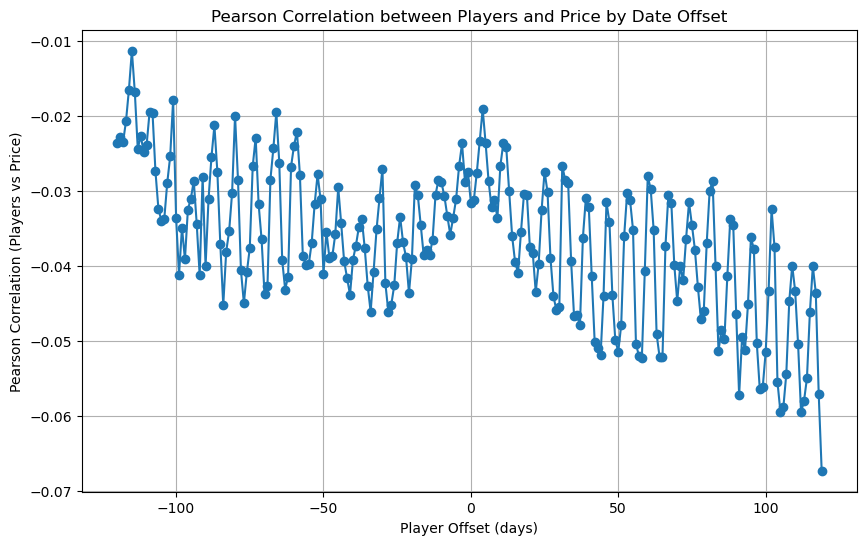

In [67]:
tf_players = pd.read_csv('./PlayerCount/tf2playercount.csv')

tf_players.info()

# Filter the tf dataset for a specific item
item_name = "Mann Co. Supply Crate Series #57"
tf_filtered = tf[tf['Item Name'] == item_name]

# print(tf_filtered)

# Filter the tf dataset for items containing "Mann Co. Supply Crate Series" in their name
# tf_filtered = tf[tf['Item Name'].str.contains("Mann Co. Supply Crate Series", case=False, na=False)]


correlations = []

for offset in range(-120, 120):
    tf_players_offset = tf_players.copy()

    tf_players_offset['DateTime'] = pd.to_datetime(tf_players['DateTime']) + pd.Timedelta(days=offset)
    # if offset < 0:
    #     tf_players_offset['DateTime'] = pd.to_datetime(tf_players['DateTime']) - pd.Timedelta(days=offset)
    # else:
    #     tf_players_offset['DateTime'] = pd.to_datetime(tf_players['DateTime']) + pd.Timedelta(days=offset)

    merged_df = pd.merge_asof(tf_filtered.sort_values('DateTime'),
                              tf_players_offset.sort_values('DateTime'),
                            on='DateTime', tolerance=pd.Timedelta('1D'), direction='nearest')
    
    # # Replace NaN values in 'Players' with 0
    # merged_df['Players'].fillna(0, inplace=True)

    # # Interpolate to fill missing values in 'Players' and 'Price'
    # merged_df['Price'] = merged_df['Price'].interpolate(method='linear')
    
    # Drop rows with NaN values specifically in 'Players' or other columns to be correlated
    merged_df.dropna(subset=['Players', 'Price'], inplace=True)

    # Check if there are enough data points
    if merged_df.shape[0] < 2:
        print(f"Offset: {offset}, Not enough data points for correlation.")
        continue  # Skip to the next iteration if not enough data
    
    corr_players_price, _ = pearsonr(merged_df['Players'], merged_df['Price'])

    correlations.append((offset, corr_players_price))

correlations_df = pd.DataFrame(correlations, columns=['Offset', 'Correlation'])

# Plot the correlation results
plt.figure(figsize=(10, 6))
plt.plot(correlations_df['Offset'], correlations_df['Correlation'], marker='o', linestyle='-')
plt.xlabel('Player Offset (days)')
plt.ylabel('Pearson Correlation (Players vs Price)')
plt.title('Pearson Correlation between Players and Price by Date Offset')
plt.grid(True)
plt.show()

##### 2.4 Game Price (Financial Data)

CS2

In [ ]:
cs_price = pd.read_csv('./GamePrice/cs2gamepricehistory.csv')

TF2

Use Orange Box (TF2 included in bundle)
F2P June 23, 2011

In [ ]:
tf_price = pd.read_csv('./GamePrice/orangeboxgamepricehistory.csv')

##### Review Sentiment

CS2

TF2

#### 3. Outlier Detection and Handling

#### 4. Pearson Coefficients and Heatmap

#### 5. Machine Learning Algorithms

##### 5.1 Linear Regression